In [189]:
import psycopg2
import matplotlib.pyplot as plt 
import csv
import pandas as pd
import numpy as np
import seaborn as sns

In [124]:
def plot_unique_user_difference(dataset, created_at_year, user_id='user_id'):
    # Get a dict of unique user_id for each year
    unique_user_id = {}
    for year in dataset[created_at_year].unique():
        unique_user_id[year] = dataset[dataset[created_at_year] == year][user_id].unique()

    # Count the difference between unique user_id for each year
    unique_user_id_diff = {}
    for year in dataset[created_at_year].unique():
        if year != dataset[created_at_year].min():
            unique_user_id_diff[year] = np.setdiff1d(unique_user_id[year], 
                                                     unique_user_id[year-1]).shape[0]

    # Plot the difference between unique user_id for each year as a scatter plot
    plt.figure(figsize=(7, 3))
    plt.grid(True)
    plt.scatter(unique_user_id_diff.keys(), unique_user_id_diff.values())
    plt.xlabel('Year')
    plt.ylabel('Number of unique users')
    plt.ylim(0, 1000)

### 1. Extracting data from the PostgreSQL database

In [125]:
def export_to_csv(sql_command, filename, user, dbname):
    conn = psycopg2.connect(
        user=user,
        dbname=dbname
    )
    cursor = conn.cursor()
    cursor.execute(sql_command)
    rows = cursor.fetchall()
    with open(filename, "w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([desc[0] for desc in cursor.description])
        csv_writer.writerows(rows)
    cursor.close()
    conn.close()

In [126]:
select_data_sql_1 = """
SELECT
    words.id AS word_id,
    words.body AS word_body,
    words.created_at AS word_created_at,
    words.user_id AS word_user_id,
    translations.id AS translation_id,
    translations.body AS translation_body,
    translations.rating,
    translations.created_at AS translation_created_at,
    translations.user_id AS translation_user_id,
    words.translations_count
FROM
    words
LEFT JOIN
    translations ON words.id = translations.word_id
ORDER BY
    words.id ASC,
    translations.created_at ASC;
"""


select_data_sql_2 = """
SELECT * FROM votes;
"""

In [127]:
export_to_csv(select_data_sql_1, "../data/words_translations.csv", "alexeykoshevoy", "slovotvir")

In [128]:
export_to_csv(select_data_sql_2, "../data/votes.csv", "alexeykoshevoy", "slovotvir")

### 2. Preparing the data for analysis

In [129]:
votes = pd.read_csv("../data/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
votes['created_at_year'] = votes['created_at'].dt.year

In [130]:
votes['user_id'].unique().shape

(5078,)

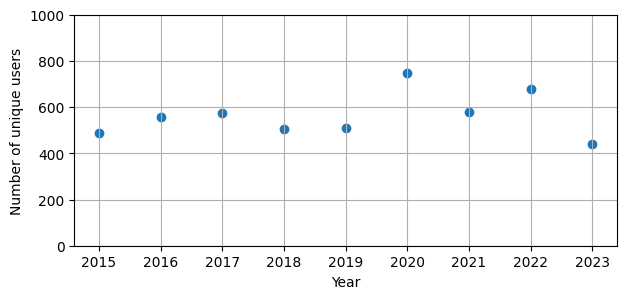

In [131]:
plot_unique_user_difference(votes, 'created_at_year')

In [132]:
df = pd.read_csv('../data/words_translations.csv')
df = df.dropna(subset=['rating'])
df['rating'] = df['rating'].astype(int)
# only keep rows where rating is not 0
df = df[df['rating'] != 0]
# subtract mean and divide by std per word
df['rating_n'] = df.groupby('word_id')['rating'].transform(lambda x: (x - x.mean()) / x.std())
df['translation_created_at'] =  pd.to_datetime(df['translation_created_at'])
df['translation_created_at_year'] = df['translation_created_at'].dt.year
df['word_created_at'] = pd.to_datetime(df['word_created_at'])
df['word_created_at_year'] = df['word_created_at'].dt.year

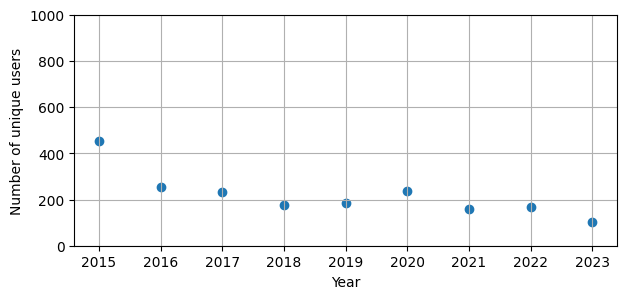

In [133]:
plot_unique_user_difference(df, 'translation_created_at_year', user_id='translation_user_id')

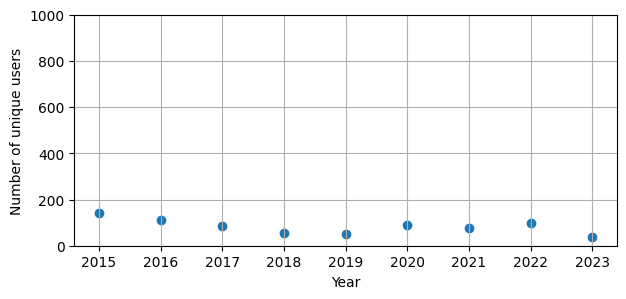

In [135]:
plot_unique_user_difference(df, 'word_created_at_year', user_id='word_user_id')

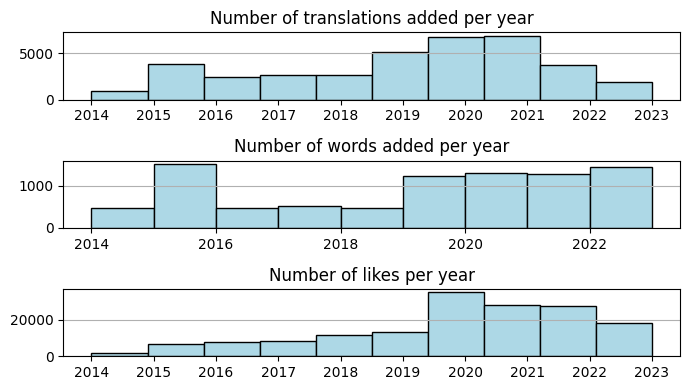

In [136]:
# plot translations per year and likes per year on the same plot as two subplots organized in 2 rows and 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 4))
df['translation_created_at_year'].hist(ax=axes[0], histtype='bar', ec='black', color='lightblue', grid=False, align='mid')
# add grid lines only horizontally
axes[0].grid(axis='y')
axes[0].set_title('Number of translations added per year')
# add x ticks for each year
axes[0].set_xticks(np.arange(df['translation_created_at_year'].min(), df['translation_created_at_year'].max()+1, 1.0))
votes['created_at_year'].hist(ax=axes[2], histtype='bar', ec='black', color='lightblue', grid=False, align='mid')
axes[2].grid(axis='y')
axes[2].set_title('Number of likes per year')
# add x ticks for each year
axes[2].set_xticks(np.arange(votes['created_at_year'].min(), votes['created_at_year'].max()+1, 1.0))
# word_created_at_year (only unique words)
df_unique_words = df.drop_duplicates(subset=['word_id'])
df_unique_words['word_created_at_year'].hist(ax=axes[1], histtype='bar', ec='black', color='lightblue', grid=False, align='mid'
                                                , bins=np.arange(df_unique_words['word_created_at_year'].min(),             
                                                                    df_unique_words['word_created_at_year'].max()+1, 1.0))                                                              
axes[1].grid(axis='y')
axes[1].set_title('Number of words added per year')
# add x ticks for each year
plt.tight_layout()
plt.show()

In [137]:
# count number of unique words and translations
print('Number of unique words: {}'.format(df['word_id'].unique().shape[0]))
print('Number of unique translations: {}'.format(df['translation_id'].unique().shape[0]))
# number of likes 
print('Number of likes: {}'.format(votes.shape[0]))
# number of users
print('Number of users: {}'.format(votes['user_id'].unique().shape[0]))

Number of unique words: 8740
Number of unique translations: 37008
Number of likes: 158238
Number of users: 5078


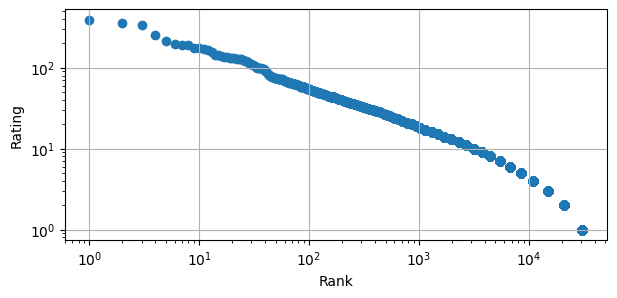

In [138]:
# plot the rank (ranked by rating) on the x-axis and the rating on the y-axis as a scatter plot using matplotlib
plt.figure(figsize=(7, 3))
plt.grid(True)
plt.scatter(df['rating'].rank(ascending=False,), df['rating'])
# log log scale
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Rating')
plt.show()

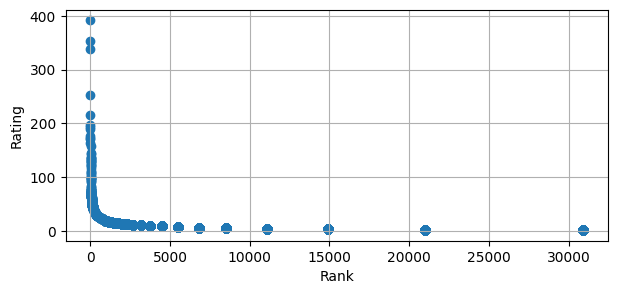

In [139]:
# plot the rank (ranked by rating) on the x-axis and the rating on the y-axis as a scatter plot using matplotlib
plt.figure(figsize=(7, 3))
plt.grid(True)
plt.scatter(df['rating'].rank(ascending=False), df['rating'])
plt.xlabel('Rank')
plt.ylabel('Rating')
plt.show()

In [155]:
# let's separate the duration of the dataset in 100 equal intervals
df['translation_created_at'].min()
df['translation_created_at'].max()
# create 100 bins
bins = pd.date_range(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=100)
# add a new column to the dataframe with the bin number
df['bin'] = pd.cut(df['translation_created_at'], bins=bins, labels=np.arange(1, 100, 1))

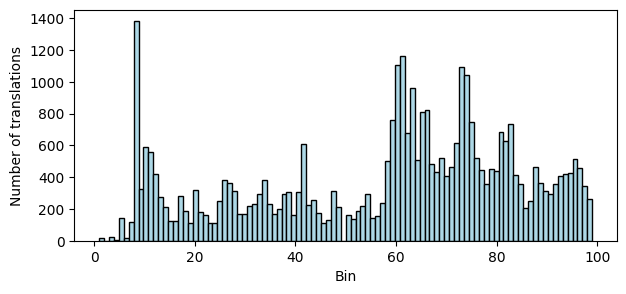

In [156]:
# plot the number of translations per bin
plt.figure(figsize=(7, 3))
plt.grid(True)
df['bin'].hist(bins=100, ec='black', color='lightblue', grid=False, align='mid')
plt.xlabel('Bin')
plt.ylabel('Number of translations')
plt.show()

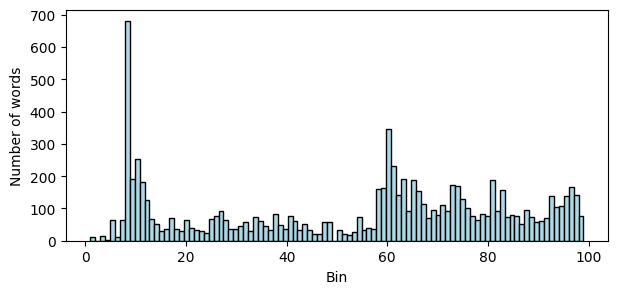

In [158]:
# plot the number of words per bin
plt.figure(figsize=(7, 3))
plt.grid(True)
df_unique_words = df.drop_duplicates(subset=['word_id'])
df_unique_words['bin'].hist(bins=100, ec='black', color='lightblue', grid=False, align='mid')
plt.xlabel('Bin')
plt.ylabel('Number of words')
plt.show()

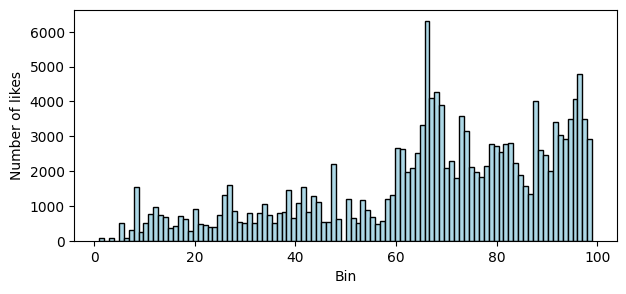

In [159]:
# add bins to the votes dataframe
votes['bin'] = pd.cut(votes['created_at'], bins=bins, labels=np.arange(1, 100, 1))

# plot the number of likes per bin
plt.figure(figsize=(7, 3))
plt.grid(True)
votes['bin'].hist(bins=100, ec='black', color='lightblue', grid=False, align='mid')
plt.xlabel('Bin')
plt.ylabel('Number of likes')
plt.show()

In [182]:
# for every user in every bin, count the number of translations and words
df_grouped = df.groupby(['bin', 'translation_user_id']).agg({'translation_id': 'count', 'word_id': 'nunique'}).reset_index()
df_grouped.columns = ['bin', 'user_id', 'translations', 'words']
# divise the number of words by the sum in bin to get the percentage of words
df_grouped['words'] = df_grouped['words'] / df_grouped.groupby('bin')['words'].transform('sum')
# divise the number of translations by the sum in bin to get the percentage of translations
df_grouped['translations'] = df_grouped['translations'] / df_grouped.groupby('bin')['translations'].transform('sum')
# remove users that don't have any translation or word in a bin
# df_grouped = df_grouped[(df_grouped['translations'] > 0) | (df_grouped['words'] > 0)]
df_grouped.shape

(194139, 4)

In [183]:
# count the number of active users in each bin
df_active_users = df.groupby('bin')['translation_user_id'].nunique().reset_index()
df_active_users.columns = ['bin', 'active_users']
df_active_users

,bin,active_users
0,1,5
1,2,0
2,3,7
3,4,1
4,5,26
...,...,...
94,95,52
95,96,67
96,97,45
97,98,59


In [184]:
# for every user in every bin, count the number of likes
votes_grouped = votes.groupby(['bin', 'user_id']).agg({'translation_id': 'count'}).reset_index()
votes_grouped.columns = ['bin', 'user_id', 'likes']
# divise the number of likes by the sum in bin to get the percentage of likes
votes_grouped['likes'] = votes_grouped['likes'] / votes_grouped.groupby('bin')['likes'].transform('sum')
# merge the two dataframes
df_grouped = df_grouped.merge(votes_grouped, on=['bin', 'user_id'], how='left')
# fill the NaN values with 0
df_grouped['likes'] = df_grouped['likes'].fillna(0)

In [185]:
# remove users where translation or word or like is 0
# df_grouped = df_grouped[(df_grouped['translations'] > 0) | (df_grouped['words'] > 0) | (df_grouped['likes'] > 0)]
df_grouped.shape

(194139, 5)

In [186]:
df_grouped

,bin,user_id,translations,words,likes
0,1,2.0,0.466667,0.500000,0.027027
1,1,4.0,0.066667,0.083333,0.000000
2,1,7.0,0.066667,0.083333,0.094595
3,1,8.0,0.000000,0.000000,0.000000
4,1,10.0,0.000000,0.000000,0.000000
...,...,...,...,...,...
194134,99,11240.0,0.003774,0.004695,0.000343
194135,99,11243.0,0.011321,0.014085,0.004799
194136,99,11260.0,0.003774,0.004695,0.000000
194137,99,11261.0,0.003774,0.004695,0.000343


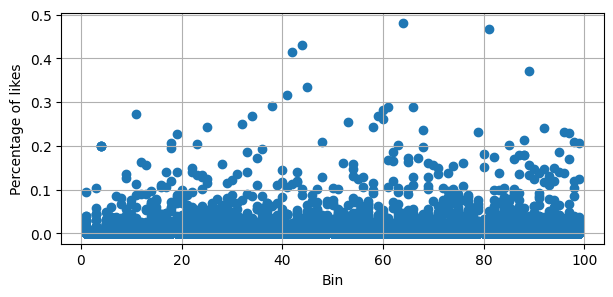

In [187]:
# plot user dynamics for likes
plt.figure(figsize=(7, 3))
plt.grid(True)
plt.scatter(df_grouped['bin'], df_grouped['likes'])
plt.xlabel('Bin')
plt.ylabel('Percentage of likes')
plt.show()

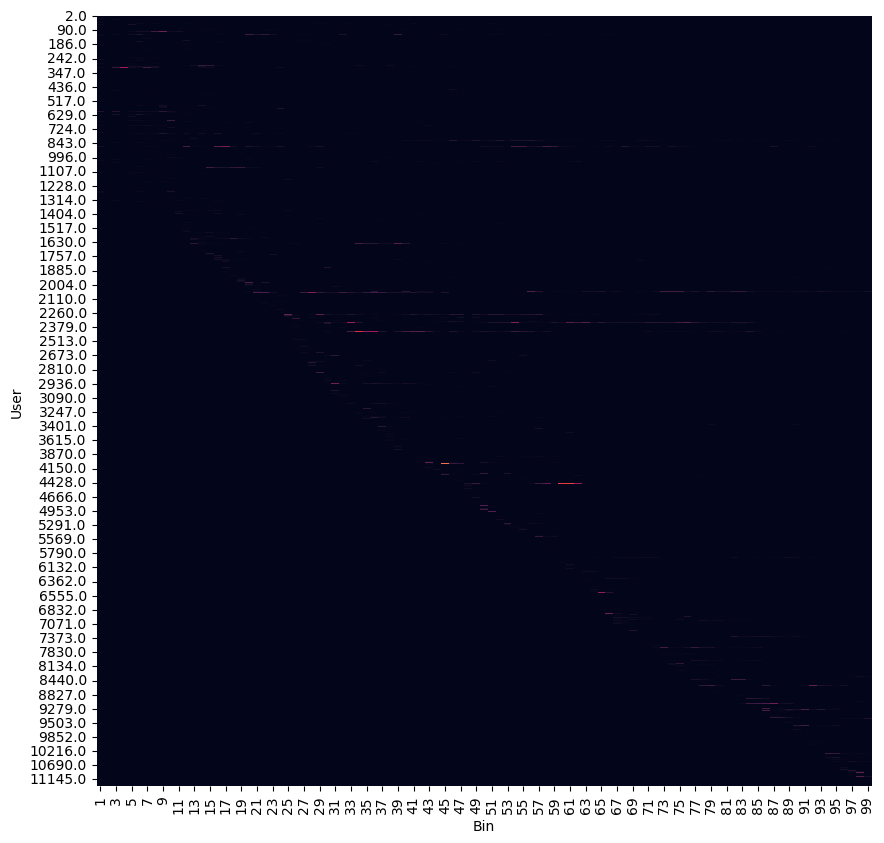

In [193]:
# create a matrix of likes per user and bin
df_pivot_likes = df_grouped.pivot(index='user_id', columns='bin', values='likes')
df_pivot_likes = df_pivot_likes.fillna(0)

# plot the heatmap
plt.figure(figsize=(10, 10))
plt.grid(True)
sns.heatmap(df_pivot_likes, cbar=False)
plt.xlabel('Bin')
plt.ylabel('User')
plt.show()

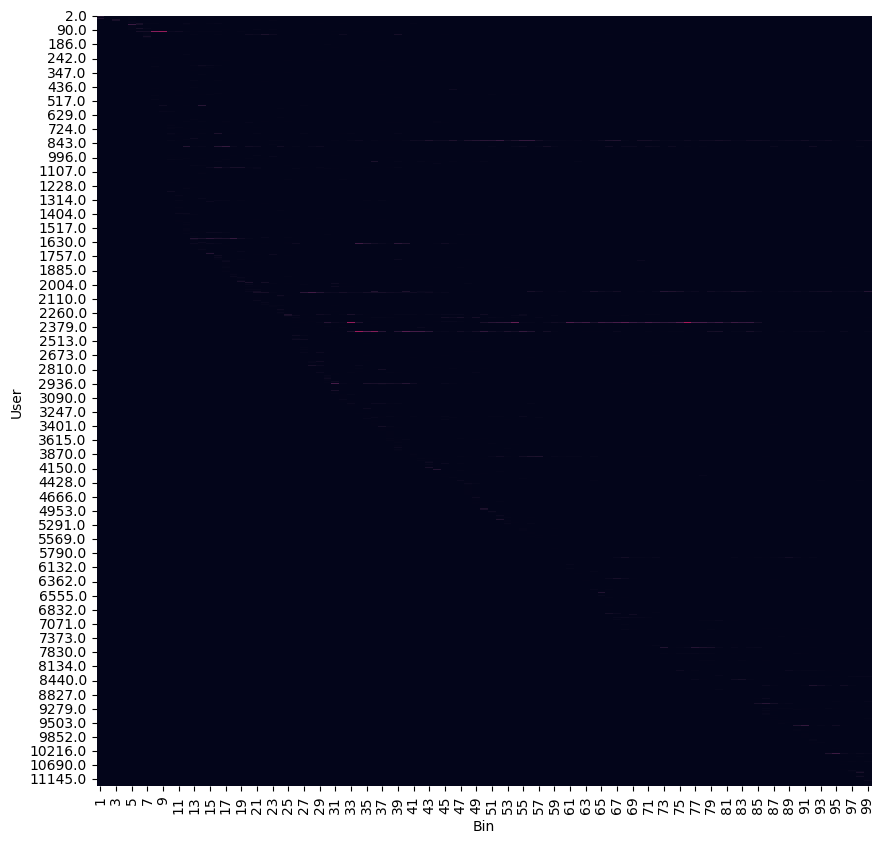

In [195]:
# create a matrix of words per user and bin
df_pivot_words = df_grouped.pivot(index='user_id', columns='bin', values='words')
df_pivot_words = df_pivot_words.fillna(0)

# plot the heatmap
plt.figure(figsize=(10, 10))
plt.grid(True)
sns.heatmap(df_pivot_words, cbar=False)
plt.xlabel('Bin')
plt.ylabel('User')
plt.show()

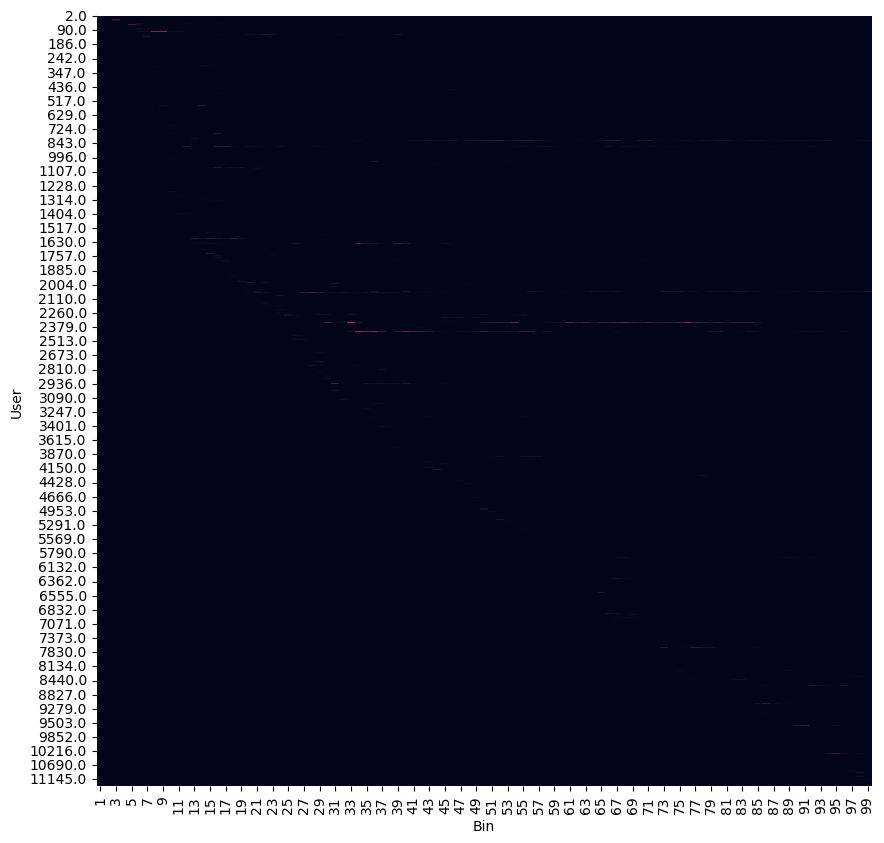

In [196]:
# create a matrix of words per user and bin
df_pivot_translations = df_grouped.pivot(index='user_id', columns='bin', values='translations')
df_pivot_translations = df_pivot_translations.fillna(0)

# plot the heatmap
plt.figure(figsize=(10, 10))
plt.grid(True)
sns.heatmap(df_pivot_translations, cbar=False)
plt.xlabel('Bin')
plt.ylabel('User')
plt.show()